# Cybersecurity & AI Case studies Project

---
## Read Me:

This notebook contains the full program code for Parts A - C of the project. The programs settings can be changed to run just Parts A, B or C depending of what is required.

The program will create a folder called 'runs' if it does not already exist and will then create a folder within this each time the program is run. This folder will contain the created graphs and charts along with a comprehensive log file.

__It is recommended to run this notebook by using the _Run All_ function and to _Restart the Kernel_ before each use.__

Settings:

- [Settings](#settings)
- [Poisoning Settings](#poison_settings)

Sections:
- [Part A](#part_a)
- [Part B](#part_b)
- [Part C](#part_c)

---
## Import required Libraries

In [1]:
# ------------------------- IMPORTS -------------------------
import sys
import os
import datetime
import time
import re
import inspect
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

from transformers import TFAutoModel, AutoTokenizer

import warnings
warnings.filterwarnings("ignore")

---
## Create Helper Functions & Custom Logger

This section contains the helper functions for all elements of the program. This includes the evaluate model function, which takes the results from each model run and provides the Accuracy, Precision, Recall and F1-score metrics.

The Custom Logger class and functions is responsible for capaturing the run log.

In [2]:
# ------------------------- HELPER FUNCTIONS -------------------------
results = {}
conf_matrices = {}

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}
    conf_matrices[name] = confusion_matrix(y_true, y_pred)

    print(f"=== Evaluation Results for {name} ===")
    print(f"{'Accuracy:':<12} {acc:.4f}")
    print(f"{'Precision:':<12} {prec:.4f}")
    print(f"{'Recall:':<12} {rec:.4f}")
    print(f"{'F1-Score:':<12} {f1:.4f}")

def time_str(time): 
    if time:
        hours = int((time // 3600) % 24)
        minutes = int((time % 3600) // 60)
        seconds = int(time % 60)
        time_str = f"{hours:02}:{minutes:02}:{seconds:02}"
    else:
        time_str = "00:00:00"
    return time_str

def format_poisoning_label(poisoned_data, poisoning_functions):
    if not poisoned_data or not poisoning_functions:
        return "(Normal Data)"
    else:
        readable = [func.__name__.replace('_', ' ').title() for func in poisoning_functions]
        return f"(Poisoned Data: {', '.join(readable)})"

def format_log_filename(run_folder):
    base_name = os.path.basename(run_folder)
    return f"{base_name}_Run_Log.txt"

def format_chart_filename(run_folder, title, poisoned_data):
    base_name = os.path.basename(run_folder)
    safe_title = title.replace(" ", "_")
    return f"{base_name}_{safe_title}.png"

def format_anomaly_csv_filename(run_folder, title):
    import os
    base_name = os.path.basename(run_folder)
    safe_title = title.replace(" ", "_").lower()
    return f"{base_name}_{safe_title}.csv"

In [3]:
# ------------------------- CUSTOM LOGGER FUNCTIONS -------------------------
class CustomLogger:
    def __init__(self, base_folder='runs', filename=None, poisoned_data=False):
        base_dir = os.getcwd() 
        runs_path = os.path.join(base_dir, base_folder)
        os.makedirs(runs_path, exist_ok=True)

        # Auto-increment subfolder: run1, run2, ...
        self.run_folder = self._get_next_run_folder(runs_path, poisoned_data)
        os.makedirs(self.run_folder, exist_ok=True)

        # Default filename if not given
        if not filename:
            filename = format_log_filename(self.run_folder)

        self.run_id = re.search(r'(Run\d+)', os.path.basename(self.run_folder)).group(1)
        self.log_path = os.path.join(self.run_folder, filename)
        self.log_file = open(self.log_path, 'w')
        self.terminal = sys.__stdout__

    def _get_next_run_folder(self, runs_path, poisoned_data):
        existing = [d for d in os.listdir(runs_path) if os.path.isdir(os.path.join(runs_path, d))]
        
        # Only match "Run#" folders
        run_nums = []
        for d in existing:
            match = re.search(r'Run(\d+)', d)
            if match:
                run_nums.append(int(match.group(1)))

        next_num = max(run_nums, default=0) + 1

        date_str = datetime.datetime.now().strftime('%y%m%d')
        run_id = f"Run{next_num}"
        status = "Poisoned_Data" if poisoned_data else "Clean_Data"

        folder_name = f"{date_str}_{run_id}_{status}"
        return os.path.join(runs_path, folder_name)

    def write(self, message):
        if message.strip():
            prefix = self._get_prefix()
            final_message = f"{prefix} {message}"
            self.terminal.write(final_message)
            self.log_file.write(final_message)
        else:
            self.terminal.write(message)
            self.log_file.write(message)

    def flush(self):
        self.terminal.flush()
        self.log_file.flush()

    def _get_prefix(self):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        func_name = inspect.stack()[2].function
        if func_name == "<module>":
            func_name = "pipeline"
        func_name = func_name.replace('<', '').replace('>', '')
        return f"[{timestamp}] [{func_name}]"

    def close(self):
        self.log_file.close()

---
<a id='part_a'></a>
## PART A: Machine Learning Models

This section defines both the Load Data function and the individual model functions for each ML/NN AI Model. The settings section allows control of which models are included in each of the program.

Models:
- Random Forest
- Gradient Boosting
- SVC
- MLP
- Decision Tree
- KNN
- Logistic Regression
- Naïve Bayes
- LSTM
- CNN
- Transformer


In [4]:
# ------------------------- RANDOM FOREST MODEL FUNCTION -------------------------
def run_random_forest(X_train, X_test, y_train, y_test, feature_names, top_n=10, return_importance=False):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    evaluate_model("Random Forest", y_test, y_pred)

    return model


In [5]:
# ------------------------- GRADIENT BOOSTING MODEL FUNCTION -------------------------
def run_gradient_boosting(X_train, X_test, y_train, y_test, feature_names):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("Gradient Boosting", y_test, y_pred)

    return model

In [6]:
# ------------------------- SVC MODEL FUNCTION -------------------------
def run_svc(X_train, X_test, y_train, y_test, feature_names):
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("SVC", y_test, y_pred)

    return model

In [7]:
# ------------------------- MLP MODEL FUNCTION -------------------------
def run_mlp(X_train, X_test, y_train, y_test, feature_names):
    model = MLPClassifier(max_iter=300)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("MLP", y_test, y_pred)

    return model

In [8]:
# ------------------------- DECISION TREE MODEL FUNCTION -------------------------
def run_decision_tree(X_train, X_test, y_train, y_test, feature_names, top_n=10, return_importance=False):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    evaluate_model("Decision Tree", y_test, y_pred)

    return model

In [9]:
# ------------------------- KNN MODEL FUNCTION -------------------------
def run_knn(X_train, X_test, y_train, y_test, feature_names):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("KNN", y_test, y_pred)

    return model

In [10]:
# ------------------------- LOGISTIC REGRESSION MODEL FUNCTION -------------------------
def run_logistic_regression(X_train, X_test, y_train, y_test, feature_names):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("Logistic Regression", y_test, y_pred)

    return model

In [11]:
# ------------------------- NAIVE BAYES MODEL FUNCTION -------------------------
def run_naive_bayes(X_train, X_test, y_train, y_test, feature_names):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    evaluate_model("Naive Bayes", y_test, y_pred)

    return model

In [12]:
# ------------------------- LSTM MODEL FUNCTION -------------------------
def run_lstm(X_train, X_test, y_train, y_test, feature_names):
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test_lstm) > 0.5).astype("int32").flatten()
    
    evaluate_model("LSTM", y_test, y_pred)

    return model

In [13]:
# ------------------------- CNN MODEL FUNCTION -------------------------
def run_cnn(X_train, X_test, y_train, y_test, feature_names):
    X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test_cnn) > 0.5).astype("int32").flatten()
    
    evaluate_model("CNN", y_test, y_pred)

    return model

In [14]:
# ------------------------- TRANSFORMER MODEL FUNCTION -------------------------
def run_transformer(X_train, X_test, y_train, y_test, feature_names):
    X_train_tf = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test_tf = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    input_layer = tf.keras.Input(shape=(X_train_tf.shape[1], 1))
    x = tf.keras.layers.Dense(64)(input_layer)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = Flatten()(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_tf, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test_tf) > 0.5).astype("int32").flatten()
    
    evaluate_model("Transformer", y_test, y_pred)

    return model

## Load Dataset

The Load Data function role is to get the dataset from the CSV file, but to also apply preprocessing to the data including splitting, scaling and normalisation.

In addition, this function also has a role in Part B, as poisoning is applied after the steps mentioned above have been carried out.

In [15]:
# ------------------------- LOAD DATA -------------------------
def load_data(poisoned_data, poisoning_functions=[], backdoor_trigger_list=[], poisoning_percentages={}, flip_direction='0-1', features_to_poison=[]):
    df = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False)
    #df = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)

    drop_cols = [
        'frame.time', 'ip.src_host', 'ip.dst_host',
        'arp.src.proto_ipv4', 'arp.dst.proto_ipv4',
        'mqtt.protoname', 'mqtt.topic'
    ]
    df = df.drop(columns=drop_cols, errors='ignore')

    attack_type_col = df['Attack_type'] if 'Attack_type' in df.columns else None

    for col in df.select_dtypes(include=['object']).columns:
        if col != 'Attack_type':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    non_numeric_cols = df.select_dtypes(include=['object']).columns
    non_numeric_cols = [col for col in non_numeric_cols if col != 'Attack_type']
    df = df.drop(columns=non_numeric_cols, errors='ignore')

    if attack_type_col is not None:
        df['Attack_type'] = attack_type_col

    df = df.dropna()

    le_attack = LabelEncoder()
    df['Attack_label'] = le_attack.fit_transform(df['Attack_label'])

    if 'Attack_type' in df.columns:
        le_type = LabelEncoder()
        df['Attack_type'] = le_type.fit_transform(df['Attack_type'])

    X = df.drop(columns=['Attack_label', 'Attack_type'], errors='ignore')
    y = df['Attack_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    selector = VarianceThreshold(threshold=0.0)
    selector.fit(X_train)

    selected_features = X.columns[selector.get_support()].tolist()

    # Add features_to_poison back if removed
    for feature in features_to_poison:
        if feature in X.columns and feature not in selected_features:
            print(f"Re-adding '{feature}' (needed for poisoning) despite constant variance.")
            selected_features.append(feature)

    # Filter the training and test sets
    X_train = X_train[selected_features]
    X_test = X_test[selected_features]

    feature_names = selected_features

    if X_train.isnull().any().any():
        print("NaNs BEFORE scaling in X_train:")
        print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
        X_train = X_train.dropna(axis=1)
        X_test = X_test[X_train.columns]
        feature_names = X_train.columns.tolist()

    # --- Normalise ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    # Debugging NaNs
    nan_cols = X_train_scaled.columns[X_train_scaled.isnull().any()].tolist()

    if nan_cols:
        print(f" Handling {len(nan_cols)} columns that caused NaNs after scaling:")
        for col in nan_cols:
            if col in features_to_poison:
                print(f" Retaining '{col}' (used in poisoning); imputing NaNs with 0.")
                X_train_scaled[col] = X_train_scaled[col].fillna(0)
                X_test_scaled[col] = X_test_scaled[col].fillna(0)
            else:
                print(f" Dropping '{col}' (not needed for poisoning).")
                X_train_scaled = X_train_scaled.drop(columns=[col])
                X_test_scaled = X_test_scaled.drop(columns=[col])

        feature_names = X_train_scaled.columns.tolist()

    assert not X_train_scaled.isnull().any().any(), "NaNs remain in X_train_scaled after final cleanup!"
    assert not X_test_scaled.isnull().any().any(), "NaNs remain in X_test_scaled after final cleanup!"

    # === DATA POISONING (If included in Run) ===
    trigger = None
    if poisoned_data:
        shared_idx = np.random.choice(X_train_scaled.index, int(len(X_train_scaled) * 0.10), replace=False)
        trigger = backdoor_trigger_list

        X_train_scaled = X_train_scaled.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        for pf in poisoning_functions:
            print(f"Data Poisoning: {pf.__name__.replace('_', ' ').capitalize()}!")
            percentage = poisoning_percentages.get(pf, 0.0)
            if percentage != 0.0:
                print(f"Applying {pf.__name__} at {percentage*100:.1f}%")
            else:
                print(f"Applying {pf.__name__}. Percentage N/A")

            X_train_scaled = X_train_scaled.reset_index(drop=True)
            y_train = y_train.reset_index(drop=True)

            if pf.__name__ == 'flip_labels':
                X_train_scaled, y_train = pf(X_train_scaled, y_train, trigger_features=features_to_poison, shared_idx=shared_idx, direction=flip_direction)

            elif pf.__name__ == 'inject_outliers':
                X_train_scaled, y_train = pf(X_train_scaled, y_train, target_features=features_to_poison, shared_idx=shared_idx)

            elif pf.__name__ == 'backdoor_trigger':
                if not trigger:
                    trigger = []
                X_train_scaled, y_train = pf(X_train_scaled, y_train, trigger_dict=trigger, percentage=percentage, target_label=1, feature_names=feature_names)
                X_test_scaled, y_test = pf(X_test_scaled, y_test, trigger_dict=trigger, percentage=0.05, target_label=0, feature_names=feature_names)
            
            elif pf.__name__ == 'gradient_aligned_label_flipping':
                temp_model = LogisticRegression().fit(X_train_scaled, y_train)
                X_train_scaled, y_train = pf(X_train_scaled, y_train, temp_model,
                    flip_fraction=0.1,
                    restrict_to_indices=poisoned_indices
                )

            elif pf.__name__ == 'feature_collision_poisoning':
                temp_model = LogisticRegression().fit(X_train_scaled, y_train)
                X_train_scaled, y_train, poisoned_indices = pf(
                    X_train_scaled, y_train, temp_model,
                    flip_class=1, inject_class=0,
                    poison_fraction=percentage,
                    variants_per_sample=10,
                    noise_std=0.05,
                    features_to_poison=features_to_poison,
                    return_indices=True
                )

    if poisoned_data:
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_names, trigger
    else:
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_names, None

---
<a id='part_b'></a>
## PART B: Data Poisoning Functions

In this section, the Data Poisoning Functions are defined. There are more present than mentioned in the report due to experimentation with different methods and settings during development. The functions can be applied or not using the Poisoning Settings. 

Models:
- Flip Labels
- Outlier Injection
- Backdoor Trigger & Evaluation
- Gradient Label Flipping
- Feature Collision

In [16]:
# ------------------------- FLIP LABELS -------------------------
def flip_labels(X, y, percent=0.1, trigger_features=None, shared_idx=None, condition_mask=None, model=None, direction="1-0"):
    if trigger_features is None:
        trigger_features = ['tcp.flags', 'tcp.dstport', 'tcp.srcport', 'tcp.ack_raw']

    if direction == "1-0":
        print(f'flip_labels [CLASS-1 TARGETED (1-->0)] using: {trigger_features}')
        target_class = 1
    elif direction == "0-1":
        print(f'flip_labels [CLASS-0 TARGETED (0-->1)] using: {trigger_features}')
        target_class = 0
    else:
        raise ValueError("Invalid direction. Use '1-0' or '0-1'.")

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=feature_names)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    y_poisoned = y.copy()

    if model:
        # Flip most confidently classified samples of target_class
        probs = model.predict_proba(X)
        preds = model.predict(X)

        correct_idx = y[(y == target_class) & (y == preds)].index
        #flip_probs = np.abs(probs[:, 1] - 0.5)  # Lower = less confident
        #sorted_idx = pd.Series(flip_probs, index=y.index).loc[correct_idx].sort_values().index
        flip_probs = probs[:, target_class]
        sorted_idx = pd.Series(flip_probs, index=y.index).loc[correct_idx].sort_values(ascending=False).index

        n = int(len(sorted_idx) * percent)
        idx = sorted_idx[:n]
    else:
        # Flip random subset of target_class rows
        eligible_idx = y[y == target_class].index
        n = int(len(eligible_idx) * percent)
        idx = eligible_idx.to_series().sample(n, random_state=42).index

    y_poisoned.loc[idx] = 1 - y.loc[idx]
    print(f'Flipped {len(idx)} labels from class {target_class} to {1 - target_class}')
    return X, y_poisoned

In [17]:
# ------------------------- INJECT OUTLIERS -------------------------
def inject_outliers(X, y, percent=0.1, target_features=None, shared_idx=None, condition_mask=None):
    if target_features is None:
        target_features = ['tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.seq', 'tcp.ack_raw']

    print(f'Inject Outliers on: {target_features}')

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=feature_names)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_poisoned = X.copy()
    
    # Choose class-0 (benign) rows to poison
    eligible_mask = (y == 0)
    if condition_mask is not None:
        eligible_mask &= condition_mask
    eligible_indices = y[eligible_mask].index

    n = int(len(eligible_indices) * percent)
    idx = np.random.choice(eligible_indices, n, replace=False)

    # Inject malicious values from class-1 samples into these
    malicious_samples = X[y == 1].sample(n=n, random_state=42)
    for feature in target_features:
        if feature in X.columns:
            X_poisoned.loc[idx, feature] = malicious_samples[feature].values
        else:
            print(f"[inject_outliers] Skipped missing feature: {feature}")

    print(f'Injected {n} malicious-like features into benign rows')
    return X_poisoned, y

In [18]:
# ------------------------- POISON MASK -------------------------
def build_poison_mask(X, dns_only=True, src_ports=None):
    """
    Generates a boolean mask for poisoning based on DNS traffic and specific TCP source ports.
    
    Args:
        X (pd.DataFrame): The feature set.
        dns_only (bool): If True, include rows with DNS port activity (port 53).
        src_ports (list of int): A list of source ports to target (e.g., [22, 80, 443]).
        
    Returns:
        pd.Series: Boolean mask for poisoning.
    """
    conditions = []

    if dns_only:
        # Include DNS traffic by standard port (53) across TCP or UDP
        cond_dns = (X.get('udp.port', 0) == 53) | (X.get('tcp.dstport', 0) == 53) | (X.get('tcp.srcport', 0) == 53)
        conditions.append(cond_dns)

    if src_ports:
        # Target specific TCP source ports
        cond_src = X.get('tcp.srcport', pd.Series(0, index=X.index)).isin(src_ports)
        conditions.append(cond_src)

    if conditions:
        return conditions[0] if len(conditions) == 1 else conditions[0] | conditions[1]
    else:
        return pd.Series(False, index=X.index)

In [19]:
# ------------------------- BACKDOOR TRIGGER -------------------------
def backdoor_trigger(X, y, trigger_dict, target_label=1, percentage=0.01, random_state=42, feature_names=None):

    if isinstance(X, np.ndarray):
        if feature_names is None:
            raise ValueError("feature_names must be provided when X is a NumPy array.")
        X = pd.DataFrame(X, columns=feature_names)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_poisoned = X.copy()
    y_poisoned = y.copy()

    n = int(len(X_poisoned) * percentage)
    np.random.seed(random_state)
    row_indices = np.random.choice(len(X_poisoned), n, replace=False)

    for feature, trigger_value in trigger_dict.items():
        if feature not in X_poisoned.columns:
            raise ValueError(f"'{feature}' not found in X columns.")
        X_poisoned.iloc[row_indices, X_poisoned.columns.get_loc(feature)] = trigger_value

    y_poisoned.iloc[row_indices] = target_label

    return X_poisoned, y_poisoned

In [20]:
# ------------------------- BACKDOOR TRIGGER SUCCESS EVALUATION -------------------------
def evaluate_backdoor_success(model, X_test, y_test, trigger_dict, feature_names, target_label=1):
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    mask = np.ones(len(X_test), dtype=bool)
    for feature, value in trigger_dict.items():
        if feature not in feature_names:
            raise ValueError(f"Feature '{feature}' not found in feature_names list.")
        col_idx = feature_names.index(feature)
        mask &= (X_test[:, col_idx] == value)

    X_triggered = X_test[mask]
    y_triggered = y_test[mask]

    if len(X_triggered) == 0:
        print("No triggered samples found in test set.")
        return 0.0

    preds = model.predict(X_triggered)
    success_rate = (preds == target_label).mean()

    print(f"Backdoor Success Rate: {success_rate:.2%} on {len(X_triggered)} samples")
    return success_rate

In [21]:
# ------------------------- GRADIENT LABEL FLIPPING -------------------------
def gradient_aligned_label_flipping(
    X_train, y_train, model, flip_fraction=0.05, restrict_to_indices=None, return_indices=False
):
    """
    Flips labels for high-confidence predictions made by the model.
    If restrict_to_indices is provided, selects from those rows only.
    """
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    y_prob = model.predict_proba(X_train)
    y_pred = np.argmax(y_prob, axis=1)
    confidence = np.max(y_prob, axis=1)

    # Restrict candidate set if needed
    if restrict_to_indices is not None:
        candidate_indices = np.array(restrict_to_indices)
    else:
        candidate_indices = np.arange(len(y_train))

    if len(candidate_indices) == 0:
        print("No candidate samples found for flipping.")
        return X_train, y_train

    # Rank candidates by model confidence
    candidate_confidences = confidence[candidate_indices]
    top_n = int(len(candidate_indices) * flip_fraction)
    top_n = max(top_n, 1)

    top_conf_indices = np.argsort(-candidate_confidences)[:top_n]
    flip_indices = candidate_indices[top_conf_indices]

    y_flipped = y_train.copy()
    y_flipped.iloc[flip_indices] = 1 - y_flipped.iloc[flip_indices]

    print(f"Gradient-aligned label flipping applied to {len(flip_indices)} of {len(candidate_indices)} high-confidence samples.")

    if return_indices:
        return X_train, y_flipped, flip_indices.tolist()
    else:
        return X_train, y_flipped

In [22]:
# ------------------------- FEATURE COLLISION -------------------------
def feature_collision_poisoning(
    X_train, y_train, model,
    flip_class=1, inject_class=0,
    poison_fraction=0.05,
    variants_per_sample=4,
    noise_std=0.02,
    features_to_poison=None,
    return_indices=False
):
    """
    Injects harmful samples by duplicating and perturbing low-confidence samples
    from flip_class and assigning them to inject_class.
    
    poison_fraction: % of total training set to use as base samples
    variants_per_sample: number of poisoned variants per base sample
    """
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    probs = model.predict_proba(X_train)
    confidences = probs[np.arange(len(y_train)), y_train]

    mask = y_train == flip_class
    class_confidences = confidences[mask]
    class_indices = np.where(mask)[0]

    if len(class_indices) == 0:
        print(f"No samples found for flip_class={flip_class}. Skipping.")
        return X_train, y_train

    total_poison_targets = int(len(X_train) * poison_fraction)
    num_base_samples = total_poison_targets // variants_per_sample
    if num_base_samples == 0:
        print("poison_fraction too low — skipping.")
        return X_train, y_train

    low_conf_indices = class_indices[np.argsort(class_confidences)[:num_base_samples]]

    if features_to_poison is None:
        features_to_poison = X_train.columns.tolist()
    valid_features = [f for f in features_to_poison if f in X_train.columns]

    poisoned_samples = []
    poisoned_labels = []
    injected_indices = []

    for idx in low_conf_indices:
        base_sample = X_train.iloc[idx].copy()
        for _ in range(variants_per_sample):
            poisoned_sample = base_sample.copy()
            noise = np.random.normal(0, noise_std, size=len(valid_features))
            poisoned_sample[valid_features] += noise
            poisoned_samples.append(poisoned_sample)
            poisoned_labels.append(inject_class)

    poisoned_df = pd.DataFrame(poisoned_samples, columns=X_train.columns)
    poisoned_labels_series = pd.Series(poisoned_labels)

    # Record injected indices
    injected_indices = list(range(len(X_poisoned), len(X_poisoned) + len(poisoned_df)))

    X_poisoned = pd.concat([X_poisoned, poisoned_df], ignore_index=True)
    y_poisoned = pd.concat([y_poisoned, poisoned_labels_series], ignore_index=True)

    print(f"Injected {len(poisoned_samples)} poisoned samples "
          f"(base: {len(low_conf_indices)}, variants: {variants_per_sample}).")

    if return_indices:
        return X_poisoned, y_poisoned, injected_indices
    else:
        return X_poisoned, y_poisoned

---
<a id='part_c'></a>
## PART C: Poisoning Detection Function

The code in this section defines a single function with the purpose of detecting poisoning of the training data. This is done using anomaly detection and full report is saved to a CSV file whilst a summary of the Top 30 occurances is included in the Run Log.

__Please Note: At no point does this function interact with any of the poisoning functions or variables.__

In [23]:
# ------------------------- POISONING DETECTION -------------------------
""" Detect poisoning using an anomaly detection system which
combines model confidence and influence analysis to
identify samples that exhibit abnormal behaviour.  """
# def detect_poisoning(X_train, y_train):
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_train)

#     model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
#     model.fit(X_scaled, y_train)

#     probs = model.predict_proba(X_scaled)
#     preds = model.predict(X_scaled)
    
#     y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
#     true_label_probs = probs[np.arange(len(y_train_np)), y_train_np]

#     gradients = (probs[:, 1] - y_train_np).reshape(-1, 1) * X_scaled
#     avg_gradient = gradients.mean(axis=0)
#     influence_scores = gradients @ avg_gradient

#     # Normalise for anomaly score
#     conf_norm = (true_label_probs - true_label_probs.min()) / (true_label_probs.max() - true_label_probs.min())
#     infl_norm = (influence_scores - influence_scores.min()) / (influence_scores.max() - influence_scores.min())
#     anomaly_scores = (1 - conf_norm) * 0.5 + infl_norm * 0.5

#     # Change threshold values as needed
#     conf_thresh = np.percentile(true_label_probs, 20)
#     infl_thresh = np.percentile(influence_scores, 80)
#     suspicious = (true_label_probs < conf_thresh) & (influence_scores > infl_thresh)

#     df = pd.DataFrame({
#         'Index': np.arange(len(y_train_np)),
#         'True Label': y_train_np,
#         'Predicted Label': preds,
#         'Confidence': true_label_probs,
#         'Influence': influence_scores,
#         'Anomaly Score': anomaly_scores,
#         'Suspicious': suspicious
#     })

#     return df

def detect_poisoning(X_train, y_train, anomaly_threshold=0.6, min_suspicious_fraction=0.05):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
    model.fit(X_scaled, y_train)

    probs = model.predict_proba(X_scaled)
    preds = model.predict(X_scaled)
    
    y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    true_label_probs = probs[np.arange(len(y_train_np)), y_train_np]

    gradients = (probs[:, 1] - y_train_np).reshape(-1, 1) * X_scaled
    avg_gradient = gradients.mean(axis=0)
    influence_scores = gradients @ avg_gradient

    # Normalise for anomaly score
    conf_norm = (true_label_probs - true_label_probs.min()) / (true_label_probs.max() - true_label_probs.min())
    infl_norm = (influence_scores - influence_scores.min()) / (influence_scores.max() - influence_scores.min())
    anomaly_scores = (1 - conf_norm) * 0.5 + infl_norm * 0.5

    # Overall dataset anomaly score
    overall_anomaly_mean = anomaly_scores.mean()

    if overall_anomaly_mean < anomaly_threshold:
        # Dataset looks clean — no suspicious samples
        suspicious = np.array([False] * len(y_train_np))
    else:
        # Dataset looks suspicious — apply percentile-based filtering
        conf_thresh = np.percentile(true_label_probs, 20)
        infl_thresh = np.percentile(influence_scores, 80)
        suspicious = (true_label_probs < conf_thresh) & (influence_scores > infl_thresh)

        if suspicious.mean() < min_suspicious_fraction:
            # Loosen thresholds to flag more samples
            conf_thresh = np.percentile(true_label_probs, 30)
            infl_thresh = np.percentile(influence_scores, 70)
            suspicious = (true_label_probs < conf_thresh) & (influence_scores > infl_thresh)

    df = pd.DataFrame({
        'Index': np.arange(len(y_train_np)),
        'True Label': y_train_np,
        'Predicted Label': preds,
        'Confidence': true_label_probs,
        'Influence': influence_scores,
        'Anomaly Score': anomaly_scores,
        'Suspicious': suspicious
    })

    return df

---
## Model Settings & Visualisation

The Model Settings function here generates the model run list. The visualisation function generates graphs at the end of the run.

In [24]:
# ------------------------- MODEL SETTINGS FUNCTION -------------------------
def get_model_functions_list():
    model_functions = []

    if RUN_RANDOM_FOREST: model_functions.append(run_random_forest)
    if RUN_GRADIENT_BOOSTING: model_functions.append(run_gradient_boosting)
    if RUN_SVC: model_functions.append(run_svc)
    if RUN_MLP: model_functions.append(run_mlp)
    if RUN_DECISION_TREE: model_functions.append(run_decision_tree)
    if RUN_KNN: model_functions.append(run_knn)
    if RUN_LOGISTIC_REGRESSION: model_functions.append(run_logistic_regression)
    if RUN_NAIVE_BAYES: model_functions.append(run_naive_bayes)
    if RUN_LSTM: model_functions.append(run_lstm)
    if RUN_CNN: model_functions.append(run_cnn)
    if RUN_TRANSFORMER: model_functions.append(run_transformer)

    return model_functions

In [25]:
# ------------------------- VISUALISATION -------------------------
def plot_results(results, conf_matrices, save_dir=None, show=True, poisoned_data=False, poisoning_functions=None):
    title_suffix = format_poisoning_label(poisoned_data, poisoning_functions)

    # --- Plot confusion matrices ---
    for name, matrix in conf_matrices.items():
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

        main_title = f"Confusion Matrix: {name}"
        subtitle = f"{title_suffix}"
        ax.set_title(f"{main_title}\n{subtitle}", pad=10)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

        fig.subplots_adjust(top=0.85)

        if save_dir:
            filename = format_chart_filename(save_dir, f"Conf_Matrix_{name}", poisoned_data)
            path = os.path.join(save_dir, filename)
            fig.savefig(path)
            print(f"Saved: {os.path.relpath(path)}")

        if show:
            plt.show()
        else:
            plt.close(fig)

    # --- Plot performance comparison bar chart ---
    df_results = pd.DataFrame(results).T
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind='bar', ax=ax)

    full_title = f"Model Performance Comparison {title_suffix}"
    ax.set_title(full_title)
    ax.set_ylabel("Score")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(0, 1)
    ax.grid(axis='y')
    ax.legend(loc='lower right')

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)

    if save_dir:
        filename = format_chart_filename(save_dir, "Metrics_Comparison", poisoned_data)
        perf_path = os.path.join(save_dir, filename)
        fig.savefig(perf_path)
        print(f"Saved: {os.path.relpath(perf_path)}")

    if show:
        plt.show()
    else:
        plt.close(fig)

---
# Settings

<a id='poison_settings'></a>
## Poisoning Settings

This function determines the settings used during data poisoning, if being included in the run. 

__Please modify the values only.__

___Please Note: The setting to include poisoning in the run is in the General Settings section.___

In [26]:
# ------------------------- POISONING SETTINGS -------------------------
def get_poisoning_settings(poisoned_data=False):
    if poisoned_data:
        #poisoning_functions = [inject_outliers, flip_labels]
        poisoning_functions = POISONING_PRESENT_1
        backdoor_trigger_list = {'tcp.dstport': 7373,
                                 'tcp.checksum': 65535,
                                 'tcp.flags': 2,
                                 'tcp.srcport': 49152,
                                 'tcp.ack_raw': 987654321}
        poisoning_percentages = {
            feature_collision_poisoning: 0.10,
            flip_labels: 0.20,
            inject_outliers: 0.20,
            backdoor_trigger: 0.10,
        }
        flip_direction = '1-0'
        features_to_poison = ['tcp.flags',
                              'tcp.dstport',
                              'tcp.flags.ack',
                              'tcp.seq',
                              'udp.stream',
                              'tcp.srcport',
                              'tcp.checksum',
                              'icmp.seq_le',
                              'tcp.connection.rst',
                              'icmp.checksum']

    else:
        poisoning_functions = []
        backdoor_trigger_list = {}
        poisoning_percentages = []
        flip_direction = None
        features_to_poison = []

    return poisoning_functions, backdoor_trigger_list, poisoning_percentages, flip_direction, features_to_poison

<a id='settings'></a>
## General Settings

This section determines the settings used for the run. The following settings can be controlled here:
- AI Models included in the run. (Boolean: True/False)
- Model Feature Importance Report for applicable models. (Boolean: True/False)
- Data Poisoning. (Boolean: True/False)
- Data Pisoning Presets. (List of functions to include.)
- Data Poisoning Detection. (Boolean: True/False)

In [27]:
# ------------------------- SETTINGS -------------------------

# --- MODEL SETTINGS ---
RUN_RANDOM_FOREST = True
RUN_GRADIENT_BOOSTING = False
RUN_SVC = False
RUN_MLP = False
RUN_DECISION_TREE = True
RUN_KNN = False
RUN_LOGISTIC_REGRESSION = False
RUN_NAIVE_BAYES = False
RUN_LSTM = False
RUN_CNN = False
RUN_TRANSFORMER = False

# Model Feature Importance Report
#(Works for Linear Models ONLY)
GET_IMPORTANCE = False

# --- POISONING SETTINGS ---
POISONED_DATA = True

POISONING_PRESENT_1 = [inject_outliers, flip_labels]
POISONING_PRESENT_2 = [backdoor_trigger]
POISONING_PRESENT_3 = [backdoor_trigger, inject_outliers, flip_labels]
POISONING_PRESENT_4 = [feature_collision_poisoning, gradient_aligned_label_flipping]

# --- POISONING DETECTION SETTINGS ---
DETECT_POISONING = True

---
## Main Program

This is the final section of the program and is what brings everything together.

___Please Note: The console log for the run will be outputted below this cell.___

__It is recommended to run this notebook by using the _Run All_ function and to _Restart the Kernel_ before each use.__

[2025-04-28 15:48:49] [pipeline] === PIPELINE START ===
[2025-04-28 15:48:49] [pipeline] Pipeline started for Run74 at 15:48:49
[2025-04-28 15:48:49] [pipeline] Pipeline Models: run_random_forest, run_decision_tree
[2025-04-28 15:48:49] [pipeline] === POISONING SETTINGS ===
[2025-04-28 15:48:49] [pipeline] Poisoned data: True. Poisoning functions applied:
  - inject_outliers: 20.0%
  - flip_labels: 20.0%
    Flip Direction: 1-0

[2025-04-28 15:48:49] [pipeline] === LOAD DATA ===
[2025-04-28 15:48:49] [pipeline] Started at: 15:48:49. Loading data...
[2025-04-28 15:49:04] [load_data]  Handling 1 columns that caused NaNs after scaling:
[2025-04-28 15:49:04] [load_data]  Dropping 'tcp.payload' (not needed for poisoning).
[2025-04-28 15:49:05] [load_data] Data Poisoning: Inject outliers!
[2025-04-28 15:49:05] [load_data] Applying inject_outliers at 20.0%
[2025-04-28 15:49:05] [inject_outliers] Inject Outliers on: ['tcp.flags', 'tcp.dstport', 'tcp.flags.ack', 'tcp.seq', 'udp.stream', 'tcp.sr

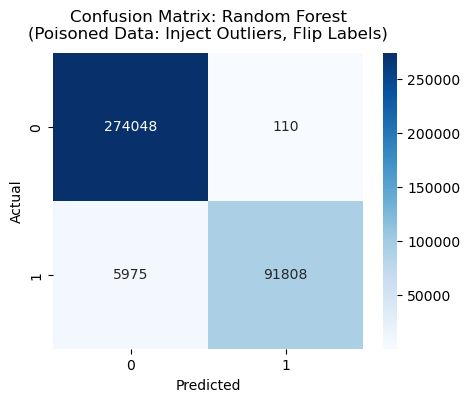

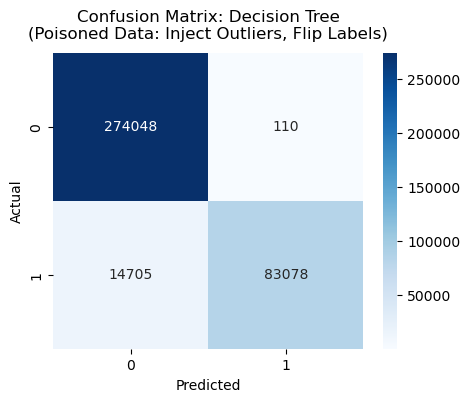

[2025-04-28 15:50:11] [evaluate_model] === Evaluation Results for Decision Tree ===
[2025-04-28 15:50:11] [evaluate_model] Accuracy:    0.9602
[2025-04-28 15:50:11] [evaluate_model] Precision:   0.9987
[2025-04-28 15:50:11] [evaluate_model] Recall:      0.8496
[2025-04-28 15:50:11] [evaluate_model] F1-Score:    0.9181
[2025-04-28 15:50:11] [pipeline] Finished 2/2: run_decision_tree in 00:00:02. Overall time: 00:01:21
[2025-04-28 15:50:11] [pipeline] === EVALUATING MODELS ===
[2025-04-28 15:50:11] [plot_results] Saved: runs/250428_Run74_Poisoned_Data/250428_Run74_Poisoned_Data_Conf_Matrix_Random_Forest.png
[2025-04-28 15:50:11] [plot_results] Saved: runs/250428_Run74_Poisoned_Data/250428_Run74_Poisoned_Data_Conf_Matrix_Decision_Tree.png


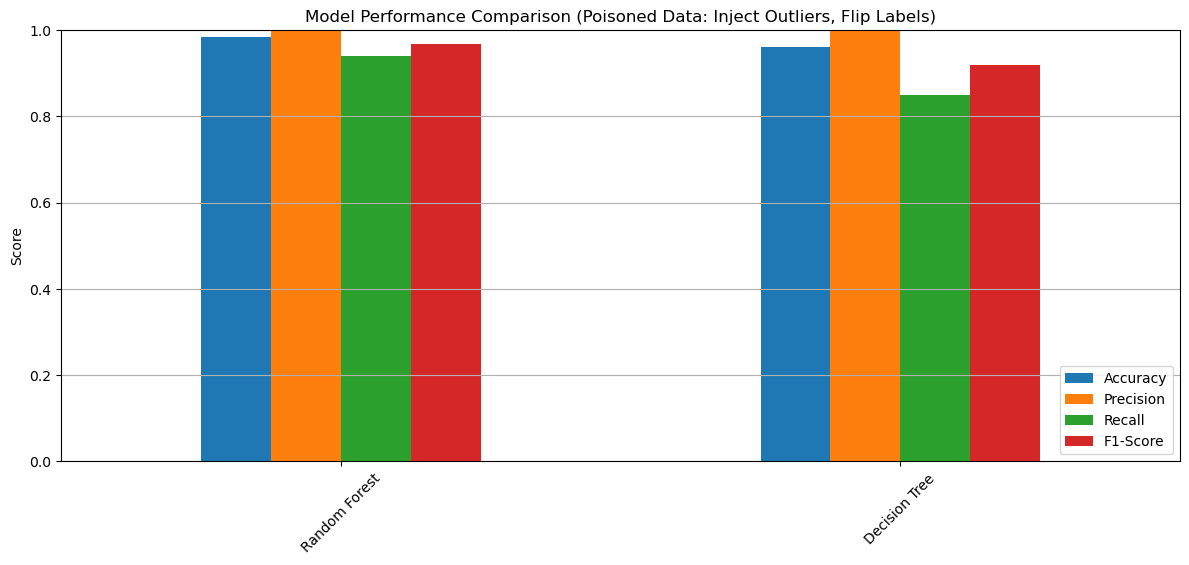

[2025-04-28 15:50:11] [plot_results] Saved: runs/250428_Run74_Poisoned_Data/250428_Run74_Poisoned_Data_Metrics_Comparison.png
[2025-04-28 15:50:11] [pipeline] === PIPELINE END ===
[2025-04-28 15:50:11] [pipeline] Pipeline finished at 15:50:11. Duration: 00:01:21


In [28]:
# ------------------------- RUN ENABLED MODELS -------------------------
# Write print statements to log file
logger = CustomLogger(poisoned_data=POISONED_DATA)
sys.stdout = logger

model_functions = get_model_functions_list()
trained_models = {}

pipelineStart = time.time()
timestamp = datetime.datetime.now().strftime('%H:%M:%S')
print("=== PIPELINE START ===")
print(f'Pipeline started for {logger.run_id} at {timestamp}')
print(f'Pipeline Models: {", ".join(f.__name__ for f in model_functions)}')

poisoning_functions, backdoor_trigger_list, poisoning_percentages, flip_direction, features_to_poison = get_poisoning_settings(POISONED_DATA)

startTime = time.time()
startTime_str = datetime.datetime.now().strftime('%H:%M:%S')
if POISONED_DATA:
    #print(f'Poisoned data: {POISONED_DATA}. Poisoning functions: {", ".join(f.__name__ for f in poisoning_functions)}')
    print("=== POISONING SETTINGS ===")
    poisoning_description = "Poisoned data: True. Poisoning functions applied:\n"

    for func in poisoning_functions:
        percent = poisoning_percentages.get(func, 0)
        poisoning_description += f"  - {func.__name__}: {percent * 100:.1f}%\n"

        if func.__name__ == "flip_labels":
            poisoning_description += f"    Flip Direction: {flip_direction}\n"

        if func.__name__ == "backdoor_trigger":
            poisoning_description += "    Backdoor trigger pattern:\n"
            for k, v in backdoor_trigger_list.items():
                poisoning_description += f"      {k}: {v}\n"

    print(poisoning_description)
else:
    print("=== CLEAN DATA ===")
    print(f'Poisoned data: {POISONED_DATA}. No poisoning functions applied.')

print("=== LOAD DATA ===")
print(f'Started at: {startTime_str}. Loading data...')
X_train, X_test, y_train, y_test, feature_names, trigger_dict = load_data(POISONED_DATA, poisoning_functions, backdoor_trigger_list, poisoning_percentages, flip_direction, features_to_poison)


if DETECT_POISONING:
    print('=== DETECTING POISONING ===')
    suspicious_df = detect_poisoning(X_train, y_train)

    # Filter only truly suspicious rows
    suspicious_subset = suspicious_df[suspicious_df['Suspicious']].copy()

    if not suspicious_subset.empty:
        # Save full suspicious subset to CSV
        poison_log_filename = format_anomaly_csv_filename(logger.run_folder, "Suspicious Samples Detected")
        poison_log_path = os.path.join(logger.run_folder, poison_log_filename)
        suspicious_subset.to_csv(poison_log_path, index=False)
        print(f"Suspicious Samples File saved: {os.path.relpath(poison_log_path)}")

        # Show top 30 suspicious samples in console
        top_suspicious = suspicious_subset.sort_values(by="Influence", ascending=False).head(30)
        print("=== POISONING DETECTION REPORT (Top 30 Rows ONLY) ===\n" + top_suspicious.to_string(index=False))
    else:
        print("No suspicious samples detected!")


total = len(model_functions)
count = 0
print("=== RUNNING MACHINE LEARNING MODELS ===")
for func in model_functions:
    start = time.time()
    start_str = datetime.datetime.now().strftime('%H:%M:%S')
    count += 1
    print(f"Running {count}/{total}: {func.__name__} at {start_str}")
    model = func(X_train, X_test, y_train, y_test, feature_names)
    trained_models[func.__name__] = model
    overall_time = time.time() - startTime
    overall_time_str = time_str(overall_time)
    duration = time.time() - start
    duration_time_str = time_str(duration)
    print(f"Finished {count}/{total}: {func.__name__} in {duration_time_str}. Overall time: {overall_time_str}")

print("=== EVALUATING MODELS ===")

if GET_IMPORTANCE == True:
    for name, model in trained_models.items():
        #print(f"=== FEATURE IMPORTANCE FOR {name.upper()} ===")

        if hasattr(model, "feature_importances_"):
            top_n = 10
            importances = pd.Series(model.feature_importances_, index=feature_names)
            top_features = importances.sort_values(ascending=False).head(top_n)
            print(f"=== FEATURE IMPORTANCE FOR {name.upper()} ===\n{top_features}")
        else:
            print(f" Feature importances not available for {name}.")

if POISONED_DATA == True and backdoor_trigger in poisoning_functions:
    for name, model in trained_models.items():
        print(f"\nEvaluating backdoor success for {name}...")
        evaluate_backdoor_success(model, X_test, y_test, trigger_dict, feature_names, target_label=1)
        
plot_results(results, conf_matrices, save_dir=logger.run_folder, poisoned_data=POISONED_DATA, poisoning_functions=poisoning_functions)

pipelineEnd = time.time()
pipelineDuration = time_str(pipelineEnd - pipelineStart)
pipelineEnd_str = datetime.datetime.now().strftime('%H:%M:%S')
print("=== PIPELINE END ===")
print(f'Pipeline finished at {pipelineEnd_str}. Duration: {pipelineDuration}')

---
# End of Pipeline